In [ ]:
!pip install jupyter-dash


  Using cached jupyter_dash-0.4.2-py3-none-any.whl (23 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Python310\\etc'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install --upgrade pip


Usage:   
  pip <command> [options]

no such option: --upgrade


In [25]:
!pip install dash

  Using cached dash-2.7.0-py3-none-any.whl (9.9 MB)


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python310\\Scripts\\dash-generate-components.exe' -> 'C:\\Python310\\Scripts\\dash-generate-components.exe.deleteme'

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


## Raw Trades ingestion 

In [19]:
import pandas as pd      
import numpy as np 
import dash
from dash import  dcc, html, Output, Input

df = pd.read_csv('RAW_1Week_2022_10_24to29.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df.hist(column='size',bins=[0,5,9,19,49,99,149,199,299,399,499,999,1999,2999,3999,4999,5999])
# df
## may by significant 
# , weights =df['size']
_max = df['size'].max()
_hist, bin_edges = np.histogram(df['size'],bins=[0,5,9,19,49,99,149,199,299,399,499,999,1999,2999,3999,4999,5999,9999,99999,999999,_max+1])  
_hist, bin_edges
# TODO CLEAN DATA SO THESE huge orders are not skewing the day to day / intraday coloring


(array([ 337348,  116098,  247326,  396748,  344682, 1197265,   41814,
         153947,   65456,   36784,  101930,   26347,    6216,    1623,
            844,     617,     711,     442,     267,      22], dtype=int64),
 array([      0,       5,       9,      19,      49,      99,     149,
            199,     299,     399,     499,     999,    1999,    2999,
           3999,    4999,    5999,    9999,   99999,  999999, 2528879]))

In [30]:
def to_shorthand(value):
    # Shorthand notation thresholds
    b_threshold = 1000000000
    m_threshold = 1000000
    k_threshold = 1000
    
    # Convert value to shorthand notation
    if value >= b_threshold:
        return f'{value:.1f}B'
    elif value >= m_threshold:
        return f'{value:.1f}M'
    elif value >= k_threshold:
        return f'{value:.1f}K'
    else:
        return value

# Test the function
print(to_shorthand(1000000000))  # Output: "1.0B"
print(to_shorthand(10000000))     # Output: "1.0M"
print(to_shorthand(1000))        # Output: "1.0K"
print(to_shorthand(100))         # Output: 100

1000000000.0M
10000000.0M
1000
100


### Basic Inline Plot - Trades - Agressive Buying 
bimodal distribution
    stand dev / seperate then classify 

In [17]:
import pandas as pd      
import numpy as np 
import dash
from dash import  dcc, html, Output, Input
import plotly.express as px
from jupyter_dash import JupyterDash
# import dash_bootstrap_components as dbc

# app.run_server(mode='inline')
df = pd.read_csv('csv/RAW_UNFILTERED_1Day_2022_10_24.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# was 40k to 80k
df = df[50000:60000]
df = df.drop(columns=['id','tape','u','exchange','conditions'])
df['dollar_volume']= df['price']*df['size']
# create dataframe
# df = pd.DataFrame({
#     "x": [1, 2, 3, 4, 5],
#     "y": [1, 2, 3, 4, 5]
# })

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
NY = 'America/New_York'
df['timestamp'] = df['timestamp'].dt.tz_convert(NY)

# df = df.set_index('timestamp')


def compute_percentile(df):
    # consistency_correction = 1.4826
    # _median = df['dollar_volume'].median()
    # dev_median = df['dollar_volume'] - _median
    # _mad = (dev_median.abs()).median()
    # mod_zscore = dev_median/(consistency_correction*_mad)
    # df['mod_zscore'] = mod_zscore
    mean_absolute_deviation = df['dollar_volume'].mad()
    #  mean_absolute_deviation =  (df['total_bin_dollar_volume'] - df['total_bin_dollar_volume'].mean()).abs().mean()
    df['mod_zscore'] = df['dollar_volume'].apply(lambda x: 0.6745 * (x - df['dollar_volume'].median()) / mean_absolute_deviation)
    df['percentile'] = df['mod_zscore'].rank(pct=True) *100
    return df
# create scatterplot
df = compute_percentile(df)

# df = df.set_index('timestamp')



# medians_std = df['price'].resample('100ms').agg(['median', 'std'])
# medians_std  = medians_std .dropna(subset=['median'])



C:\Users\JES\AppData\Local\Temp\ipykernel_18948\933321659.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/RAW_UNFILTERED_1Day_2022_10_24.csv', parse_dates=['timestamp'], infer_datetime_format=True)


In [27]:

def newDataframe(group):
    # Check if the group DataFrame has a 'price' column
    
    mean_absolute_deviation = group['price'].mad()
    if mean_absolute_deviation != 0 :
        # group = group.dropna(subset=['price'])

        # group_median = group['price'].median()
        group['ms_mod_zscore'] = group['price'].apply(lambda x: 0.6745 * (x - group['price'].median()) / mean_absolute_deviation)
        group['aggressor'] = np.where(group['ms_mod_zscore'] >= 0.6,1, 0)
        group['aggressor'] = np.where(group['ms_mod_zscore'] <= -0.6, -1, group['aggressor'])
    else:
        # If the group DataFrame does not have a 'price' column, print a warning message
        # print("Warning: 'price' column not found in group DataFrame")
        # print(group)
        group['aggressor'] =0

    return group

def g(group):
    if len(group) == 0:
        return group
    else:
        return newDataframe(group )

# df = df.reset_index()


grouped =  df.groupby(pd.Grouper( key='timestamp',freq='100ms'), as_index=False)

grouped= grouped.apply(g) 
# grouped = grouped.swaplevel().reset_index()
# grouped = grouped.drop(columns=['level_0', 'level_1'])
grouped

# df
# grouped
# fig = px.scatter(df, x="timestamp", y="price", color='aggressor',title="Dash Scatterplot")

# # show plot
# # fig.show()
# mygraph = dcc.Graph(
#     id='basic-interactions',
#     figure = fig,
#     config = {'scrollZoom': True,'displaylogo': False}
# )
# app = JupyterDash(__name__)
# app.layout = html.Div([
#     # html.H1("X-Ray Chart"),
#     # dbc.Row([
#     #     dbc.Col([mygraph], width=12),
#     #     # dbc.Col([histogram_graph], width=4),
#     # ]),
#     mygraph
    
# ])
# app.run_server(mode="inline")
# medians_std

,timestamp,price,size,dollar_volume,mod_zscore,percentile,ms_mod_zscore,aggressor
50000,2022-10-24 09:38:06.181568210-04:00,377.5299,9,3397.7691,-0.605595,12.610,0.000000,0.0
50001,2022-10-24 09:38:06.186857-04:00,377.5300,41,15478.7300,-0.391485,34.840,1.517625,1.0
50002,2022-10-24 09:38:06.187095466-04:00,377.5299,41,15478.7259,-0.391485,34.830,0.000000,0.0
50003,2022-10-24 09:38:06.211710956-04:00,377.5300,17,6418.0100,-0.552067,22.255,-1.124167,-1.0
50004,2022-10-24 09:38:06.211955-04:00,377.5300,201,75883.5300,0.679061,90.460,-1.124167,-1.0
...,...,...,...,...,...,...,...,...
59995,2022-10-24 09:41:11.775254-04:00,375.7600,70,26303.2000,-0.199645,42.620,0.567477,0.0
59996,2022-10-24 09:41:11.779034-04:00,375.7500,100,37575.0000,0.000124,50.995,0.000000,0.0
59997,2022-10-24 09:41:11.779193-04:00,375.7500,70,26302.5000,-0.199657,42.605,0.000000,0.0
59998,2022-10-24 09:41:11.780703931-04:00,375.7690,10,3757.6900,-0.599216,12.990,1.078207,1.0


In [28]:
fig = px.scatter(grouped, x="timestamp", y="price", color='aggressor',title="Dash Scatterplot", hover_data=["ms_mod_zscore","dollar_volume","size"])

# show plot
# fig.show()
mygraph = dcc.Graph(
    id='basic-interactions',
    figure = fig,
    config = {'scrollZoom': True,'displaylogo': False}
)
app = JupyterDash(__name__)
app.layout = html.Div([
    # html.H1("X-Ray Chart"),
    # dbc.Row([
    #     dbc.Col([mygraph], width=12),
    #     # dbc.Col([histogram_graph], width=4),
    # ]),
    mygraph
    
])
app.run_server(mode="inline")

In [21]:
grouped.to_csv('test/classifier_test.csv',index=True)

In [18]:
medians_std

NameError: name 'medians_std' is not defined

> i have a distribution of points under the pandas column 'price' that is sometimes bimodal and sometimes unimodal ; if unimodal everything above one standard deviation from the median classify 'agg_buy' and everything one standard deviation below the median classify 'agg_sell' . For the bimodal Distribution classify everything 1 standard deviation below the median of the top mode to the highest point 'agg_buy' and everything one standard deviation above the median bottom mode to the lowest ponit 'agg_sell' 

In [ ]:
import pandas as pd

# Load the data into a pandas DataFrame
df = pd.read_csv('data.csv')

# Get summary statistics for the distribution of points
stats = df['price'].describe()

# Determine whether the distribution is unimodal or bimodal
if len(df['price'].mode()) == 1:
    # Distribution is unimodal
    median = stats['50%']
    stddev = stats['std']

    # Classify points that are more than one standard deviation above the median as 'agg_buy'
    df.loc[df['price'] > median + stddev, 'class'] = 'agg_buy'

    # Classify points that are more than one standard deviation below the median as 'agg_sell'
    df.loc[df['price'] < median - stddev, 'class'] = 'agg_sell'

else:
    # Distribution is bimodal
    # Sort the points in ascending order
    df = df.sort_values('price')

    # Find the two modes of the distribution
    modes = df['price'].mode()

    # Find the median of the lower mode
    lower_mode_median = df[df['price'] <= modes[0]]['price'].median()

    # Find the median of the upper mode
    upper_mode_median = df[df['price'] >= modes[1]]['price'].median()


In [18]:
_max

2528878


# * 3M 1 Week Bin Data CSV

In [17]:
import pandas as pd      
import numpy as np 
import dash
from dash import  dcc, html, Output, Input

df = pd.read_csv('3Min_1Week_BinData_2022_10_24to29_dollarvolume.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df
# NY = 'America/New_York'
# df['timestamp'] = df['timestamp'].dt.tz_convert(NY)

chart_df = df.copy(deep=True)

### Filter by time


In [ ]:
import pandas as pd

# load data
df = pd.read_csv('data.csv')

# convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# set time zone to NYC
df['timestamp'] = df['timestamp'].dt.tz_localize('America/New_York')

# filter to rows between 9:30am and 4pm
mask = (df['timestamp'].dt.hour >= 9) & (df['timestamp'].dt.hour < 16)
df = df[mask]


In [45]:
# df = df.reset_index()
df
# df['bin_dollar_volume'].median()
#  
from scipy import stats
# df
consistency_correction = 1.4826
_median = df['bin_dollar_volume'].median()
dev_median = df['bin_dollar_volume'] - _median
_mad = (dev_median.abs()).median()
mod_zscore = dev_median/(consistency_correction*_mad)
# mod_zscore 
df['mod_zscore'] = mod_zscore
# df['percentile']=df['mod_zscore'].describe(percentiles=[.1, .2, .3, .4, .5, .6 , .7, .8, .9, 1])
df['percentile'] = df['mod_zscore'].rank(pct=True)
df

# df.describe()
df

,timestamp,p1,p2,midpoint,bin_volume,bin_dollar_volume,tick_size,mod_zscore,percentile
0,2022-10-24 04:08:00+00:00,374.80,374.82,374.81,100,37481.00,0.02,-0.710030,0.023229
1,2022-10-24 04:09:00+00:00,374.70,374.72,374.71,66,24730.20,0.02,-0.714039,0.008596
2,2022-10-24 04:09:00+00:00,374.72,374.74,374.73,101,37847.73,0.02,-0.709914,0.028948
3,2022-10-24 04:16:00+00:00,374.82,374.84,374.83,500,187410.00,0.02,-0.662887,0.160510
4,2022-10-24 04:18:00+00:00,374.80,374.82,374.81,277,103825.14,0.02,-0.689169,0.108901
...,...,...,...,...,...,...,...,...,...
28149,2022-10-28 23:57:00+00:00,390.14,390.16,390.15,337,131480.55,0.02,-0.680473,0.131242
28150,2022-10-28 23:57:00+00:00,390.16,390.18,390.17,483,188452.11,0.02,-0.662559,0.161647
28151,2022-10-28 23:57:00+00:00,390.18,390.20,390.19,559,218112.83,0.02,-0.653233,0.179193
28152,2022-10-28 23:57:00+00:00,390.20,390.22,390.21,3853,1503452.24,0.02,-0.249080,0.426618


In [30]:
from datetime import datetime
#   firstRow = df.head(1)
_date = df['timestamp'].head(1)
# _date = _date.astype(str)

# [_date]*5
# dd= str(_date)
# dd = datetime.strftime(_date)
# dt.to_datetime(_date)
# _date.dt.strftime('%B %d, %Y, %r')
# str(_date.isoformat())
_list = _date.tolist()*5
_list

[Timestamp('2022-10-24 04:08:00+0000', tz='UTC'),
 Timestamp('2022-10-24 04:08:00+0000', tz='UTC'),
 Timestamp('2022-10-24 04:08:00+0000', tz='UTC'),
 Timestamp('2022-10-24 04:08:00+0000', tz='UTC'),
 Timestamp('2022-10-24 04:08:00+0000', tz='UTC')]

In [31]:
df.loc[df['midpoint'] == df['midpoint'].max()]



,timestamp,p1,p2,midpoint,bin_volume,bin_dollar_volume,tick_size
27913,2022-10-28 20:51:00+00:00,390.28,390.3,390.29,309,120596.62,0.02


### Timezone change

In [19]:
# df = df.reset_index()

# Change TimeZone  - ESS
# start = pd.Timestamp('2021-05-01', tz=NY).date().isoformat()
NY = 'America/New_York'
df['timestamp'] = df['timestamp'].dt.tz_convert(NY)

df

,timestamp,p1,p2,midpoint,bin_volume,bin_dollar_volume,tick_size
0,2022-10-24 00:08:00-04:00,374.80,374.82,374.81,100,37481.00,0.02
1,2022-10-24 00:09:00-04:00,374.70,374.72,374.71,66,24730.20,0.02
2,2022-10-24 00:09:00-04:00,374.72,374.74,374.73,101,37847.73,0.02
3,2022-10-24 00:16:00-04:00,374.82,374.84,374.83,500,187410.00,0.02
4,2022-10-24 00:18:00-04:00,374.80,374.82,374.81,277,103825.14,0.02
...,...,...,...,...,...,...,...
28149,2022-10-28 19:57:00-04:00,390.14,390.16,390.15,337,131480.55,0.02
28150,2022-10-28 19:57:00-04:00,390.16,390.18,390.17,483,188452.11,0.02
28151,2022-10-28 19:57:00-04:00,390.18,390.20,390.19,559,218112.83,0.02
28152,2022-10-28 19:57:00-04:00,390.20,390.22,390.21,3853,1503452.24,0.02


### Code

In [6]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd      
import numpy as np 
import plotly.graph_objects as go

# Load Data
# df = px.data.tips()
# df = pd.read_csv('raw_trades.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df = df[5400:24020]

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("X-Ray Chart"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='temps', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ]),
    ]),
    html.Div(id='selected-data')
])
# Select data and have output
@app.callback(
    Output('selected-data', 'children'),
    Input('basic-interactions', 'selectedData')
)
def display_selected_data(selectedData):
    # print(selectedData)
    return json.dumps(selectedData, indent=2)

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    # fig =  px.scatter(
    #     df, x="timestamp", y="timeTotalDollarVolume", color=10*np.log(df["timeTotalDollarVolume"]),
    #     color_continuous_scale=colorscale,
    #     render_mode="webgl", title="Dollar Volume Histogram",
    #     height = 600,
    #     mode='lines'
      
    # )
    fig = go.Figure()

    def compute_tick_resample(resample_df,_multiplier):
        # fd = resample_df
        
        # _hist
        # TODO change this FD name
        # new_fd = pd.DataFrame(list(zip(_midpoint,_hist,tick_list)),
        #                 columns =['midpoint','total_bin_dollar_volume','tick_size'])

        def newDataframe(group,_multiplier):
            # global _multiplier
            # # group['dollar_volume'] = group['bin_dollar_volume']
            
            # timeTotalDollarVolume = group['bin_dollar_volume'].sum()
            # #TODO return a dataframe with it all
            # # print(binTotal)
            # firstRow = group.head(1)
            # _date = group['timestamp'].head(1)
            # # _date = getNewDate(_date)
            # # print(_date)
            # # fd = pd.DataFrame(np.array([_date],[ timeTotalDollarVolume], ['3min']),
            # #                columns =['timestamp','timeTotalDollarVolume','timeGrouping'])
            # # d = {'timestamp': [_date], 'timeTotalDollarVolume': [timeTotalDollarVolume],'timeGrouping':['3min']}
            # firstRow['timestamp'] = _date
            # firstRow['time_total_dollar_volume'] = timeTotalDollarVolume
            # firstRow['time_grouping'] = 5 
            # # firstRow.drop(columns=['p1','p2','midpoint','bin_dollar_volume','bin_volume'])
            # # d = {'timestamp': [_date], 'price': [timeTotalDollarVolume],'size':[3]}
            # # fd = pd.DataFrame(data=d)
            # # print(fd)
            # # print(firstRow)
            _min = group['p1'].min()
            _max = group['p2'].max()
            ## need this or else we get 305.5995 which messes up bins
            _max = round(_max,2)
            _min = round(_min,2)
            tick_size = 0.0200
            _min_int =_min*100
            _max_int = _max*100
            firstRow = group.head(1)
            _date = group['timestamp'].head(1)
            # # Establish Floor and ceiling so have even numbers 
            # if( (_min_int) % 2 ==1):
            #     _min_int = _min_int - 1
            # if( (_max_int) % 2 ==1):
            #     _max_int = _max_int + 1

            #     print(_min_int)
            #     print(_max_int)
            #Creates bins from int-high, int-low seperated by 2 (100.01 is 10,001 now)
            # add +2 to max_int
            # print(f'{_min_int};{_max_int}')
            _bins_int = np.arange( _min_int, _max_int, 2*_multiplier )

            _midpoint = (_bins_int+_multiplier)/100
            _bins = _bins_int/100


            _min = _min_int/100
            _max = _max_int/100
            # len(_bins_int)
            # fd['dollar_volume'] =  fd['midpoint'] * fd['bin_volume']

            _hist, bin_edges = np.histogram(group['midpoint'], bins=_bins, weights =group['bin_dollar_volume'])  

            p1  = bin_edges[:-1]
            p2 = bin_edges[1:]

            tick_list = [tick_size*_multiplier] * _hist.size
            new_group = pd.DataFrame(list(zip(_date,_midpoint,_hist,tick_list,p1,p2)),
                            columns =['timestamp' ,'midpoint','total_bin_dollar_volume','tick_size','p1','p2'])
            return new_group

            # return group
        def g(group,_multiplier):
            if len(group) == 0:
                return group
                # return
            else:
                return newDataframe(group,_multiplier)
        # TODO - add ability to change time ; have to make a dictionary 
        grouped =  resample_df.groupby(pd.Grouper( key='timestamp',freq='3min'), as_index=False)
        # grouped.apply(g)
        grouped = grouped.apply(g,_multiplier) 
        grouped = grouped.swaplevel().reset_index()
        grouped = grouped.drop(columns=['level_0', 'level_1'])
        # grouped = grouped.drop(columns=['bin_dollar_volume','bin_volume'])
        print(grouped.columns)
        print(grouped.head(10))
        # grouped = grouped.drop(columns=['p1','p2','midpoint','zscore','tick_size','bin_dollar_volume','bin_volume'])
        return grouped


chart_df = compute_tick_resample(chart_df,2)
fig.add_trace(go.Scattergl(
    x = chart_df["timestamp"], 
    y = chart_df["midpoint"],
    mode='markers',
    marker=dict(
        # NOTE: if remove log - everything becomes green
        color=10*np.log(chart_df["total_bin_dollar_volume"]), #set color equal to a variable
        colorscale = "temps", # one of plotly colorscales
        showscale=True
    ),
    customdata= nk,
    hovertemplate = "%{y}: <br>Volume: %{customdata[0]} </br> Z-Score %{customdata[1]:.3f}<br> LogDollarVolume %{customdata[2]:.3f}</br>",
    showlegend=False
))
# fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
#                      line = dict(color='royalblue', width=4, dash='dash')))
# fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
#                      line = dict(color='firebrick', width=4, dash='dot')))
return fig 
# Run app and display result inline in the notebook
app.run_server(mode='inline')
# app.run_server(mode='jupyterlab')

NameError: name 'compute_tick_resample' is not defined

# X-Ray Chart + Callback 

In [31]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd      
import numpy as np 
import plotly.graph_objects as go

# Load Data
# df = px.data.tips()
# df = pd.read_csv('raw_trades.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df = df[5400:24020]
# df = df
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("X-Ray Chart"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='temps', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ]),
    ]),
    html.Div(id='selected-data')
])
# Select data and have output
@app.callback(
    Output('selected-data', 'children'),
    Input('basic-interactions', 'selectedData')
)
def display_selected_data(selectedData):
    # print(selectedData)
    return json.dumps(selectedData, indent=2)

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    # fig =  px.scatter(
    #     df, x="timestamp", y="timeTotalDollarVolume", color=10*np.log(df["timeTotalDollarVolume"]),
    #     color_continuous_scale=colorscale,
    #     render_mode="webgl", title="Dollar Volume Histogram",
    #     height = 600,
    #     mode='lines'
      
    # )
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['midpoint'],
                    mode='markers',
                    name='lines+markers',
                    line_color='#ffe476',
                    marker=dict(
                        # NOTE: if remove log - everything becomes green
                        color=10*np.log(df["bin_dollar_volume"]), #set color equal to a variable
                        colorscale = "temps", # one of plotly colorscales
                            showscale=True
                    ),
                )
    )
    # fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
    #                      line = dict(color='royalblue', width=4, dash='dash')))
    # fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
    #                      line = dict(color='firebrick', width=4, dash='dot')))
    return fig 
# Run app and display result inline in the notebook
app.run_server(mode='inline')
# app.run_server(mode='jupyterlab')

## ESS Need this for grouping to work 

## Get the x-axis histogram 

In [3]:
df = df.reset_index()


In [4]:
# from datetime import tzinfo, timedelta, datetime
from datetime import * 
from dateutil import parser
import time 
import math
#TODO may need to change this to return midpoint , ADD seconds 
def getNewDate(_date):
    year=int(_date.dt.year)
    month=int(_date.dt.month)
    day=int(_date.dt.day)
    hour=int(_date.dt.hour)
    seconds = 0 
    # needs to be cast to int
    minute=int(_date.dt.minute)
    _timestamp = datetime(year,month, day,hour,minute,tzinfo=timezone.utc)
    return _timestamp

def newDataframe(group):
    group['DollarVolume'] = group['price'] * group['size']
    
    timeTotalDollarVolume = group['DollarVolume'].sum()
    #TODO return a dataframe with it all
    # print(binTotal)
    firstRow = group.head(1)
    _date = group['timestamp'].head(1)
    # _date = getNewDate(_date)
    # print(_date)
    # fd = pd.DataFrame(np.array([_date],[ timeTotalDollarVolume], ['3min']),
    #                columns =['timestamp','timeTotalDollarVolume','timeGrouping'])
    # d = {'timestamp': [_date], 'timeTotalDollarVolume': [timeTotalDollarVolume],'timeGrouping':['3min']}
    firstRow['timestamp'] = _date
    firstRow['timeTotalDollarVolume'] = timeTotalDollarVolume
    firstRow['timeGrouping'] = 3 
    # firstRow.drop(columns=['DollarVolume','price','size'])
    # d = {'timestamp': [_date], 'price': [timeTotalDollarVolume],'size':[3]}
    # fd = pd.DataFrame(data=d)
    # print(fd)
    # print(firstRow)
    return firstRow

    # return group
def g(group):
    if len(df) == 0:
        return group
    else:
        return newDataframe(group)
# df = df[10000:20000]        
grouped =  df.groupby(pd.Grouper( key='timestamp',freq='3min'), as_index=False)
# grouped.apply(g)
grouped = grouped.apply(g) 
grouped = grouped.swaplevel().reset_index()
grouped = grouped.drop(columns=['level_0', 'level_1'])
grouped = grouped.drop(columns=['DollarVolume','price','size'])
# grouped.head(100)
grouped

,timestamp,timeTotalDollarVolume,timeGrouping
0,2021-06-08 08:00:00.103700+00:00,9.043622e+05,3
1,2021-06-08 08:03:01.290300+00:00,4.753895e+05,3
2,2021-06-08 08:06:02.955200+00:00,1.676074e+05,3
3,2021-06-08 08:09:00.073100+00:00,3.820123e+05,3
4,2021-06-08 08:12:07.795200+00:00,5.010501e+05,3
...,...,...,...
113,2021-06-08 13:42:00.008800+00:00,1.050663e+08,3
114,2021-06-08 13:45:00.031600+00:00,1.518005e+08,3
115,2021-06-08 13:48:00.018400+00:00,1.510266e+08,3
116,2021-06-08 13:51:00.047500+00:00,1.709872e+08,3


In [ ]:
df_quotes = pd.read_csv('', parse_dates=['timestamp'], infer_datetime_format=True)
df_quotes

In [ ]:
# %%html
# <style>
# .output_wrapper, .output {
#     height:auto !important;
#     max-height:1500px;  /* your desired max-height here */
# }
# .output_scroll {
#     box-shadow:none !important;
#     webkit-box-shadow:none !important;
# }
# </style>

In [23]:


%%html
<style>
.output_wrapper .output {
  overflow-y: visible;
  height: fit-content;
}
</style>

In [7]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd      
import numpy as np 
import plotly.graph_objects as go

# Load Data
# df = px.data.tips()
# df = pd.read_csv('raw_trades.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df = df[5400:24020]
df = grouped 
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("X-Axis $-Vol Histogram"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='temps', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    # fig =  px.scatter(
    #     df, x="timestamp", y="timeTotalDollarVolume", color=10*np.log(df["timeTotalDollarVolume"]),
    #     color_continuous_scale=colorscale,
    #     render_mode="webgl", title="Dollar Volume Histogram",
    #     height = 600,
    #     mode='lines'
      
    # )
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['timeTotalDollarVolume'],
                    mode='lines+markers',
                    name='lines+markers',
                    line_color='#ffe476',
                    marker=dict(
                        # NOTE: if remove log - everything becomes green
                        color=10*np.log(df["timeTotalDollarVolume"]), #set color equal to a variable
                        colorscale = "temps", # one of plotly colorscales
                            showscale=True
                    ),
                )
    )
    # fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
    #                      line = dict(color='royalblue', width=4, dash='dash')))
    # fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
    #                      line = dict(color='firebrick', width=4, dash='dot')))
    return fig 
# Run app and display result inline in the notebook
app.run_server(mode='inline')
# app.run_server(mode='jupyterlab')

<AxesSubplot:ylabel='Density'>

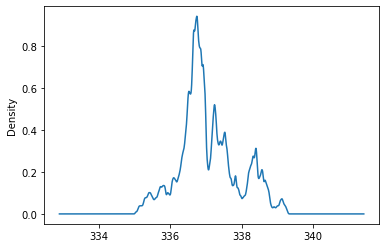

In [36]:

df_bindata = pd.read_csv('Day_BinData_6_8_2021.csv', parse_dates=['timestamp'], infer_datetime_format=True)
df_bindata
df_bindata['midpoint'].plot.kde(bw_method=0.02)

In [8]:
grouped

,timestamp,timeTotalDollarVolume,timeGrouping
0,2021-06-08 08:00:00.103700+00:00,9.043622e+05,3
1,2021-06-08 08:03:01.290300+00:00,4.753895e+05,3
2,2021-06-08 08:06:02.955200+00:00,1.676074e+05,3
3,2021-06-08 08:09:00.073100+00:00,3.820123e+05,3
4,2021-06-08 08:12:07.795200+00:00,5.010501e+05,3
...,...,...,...
113,2021-06-08 13:42:00.008800+00:00,1.050663e+08,3
114,2021-06-08 13:45:00.031600+00:00,1.518005e+08,3
115,2021-06-08 13:48:00.018400+00:00,1.510266e+08,3
116,2021-06-08 13:51:00.047500+00:00,1.709872e+08,3


In [9]:
fd = pd.read_csv('3Min_3Days_BinData_10_10_2022.csv', parse_dates=['timestamp'], infer_datetime_format=True)
fd


,timestamp,p1,p2,midpoint,BinVolume,tickSize
0,2022-10-10 04:35:00+00:00,361.78,361.80,361.79,500,0.02
1,2022-10-10 04:36:00+00:00,361.68,361.70,361.69,296,0.02
2,2022-10-10 05:48:00+00:00,361.24,361.26,361.25,184,0.02
3,2022-10-10 05:57:00+00:00,361.24,361.26,361.25,112,0.02
4,2022-10-10 07:13:00+00:00,361.80,361.82,361.81,200,0.02
...,...,...,...,...,...,...
16726,2022-10-12 23:57:00+00:00,357.62,357.64,357.63,541,0.02
16727,2022-10-12 23:57:00+00:00,357.64,357.66,357.65,1843,0.02
16728,2022-10-13 00:00:00+00:00,356.56,356.58,356.57,909084,0.02
16729,2022-10-13 00:00:00+00:00,357.56,357.58,357.57,57,0.02


In [10]:
 # Fixed the timezone issues 
 NY = 'America/New_York'
fd['timestamp'] = fd['timestamp'].dt.tz_convert(NY)
fd

,timestamp,p1,p2,midpoint,BinVolume,tickSize
0,2022-10-10 00:35:00-04:00,361.78,361.80,361.79,500,0.02
1,2022-10-10 00:36:00-04:00,361.68,361.70,361.69,296,0.02
2,2022-10-10 01:48:00-04:00,361.24,361.26,361.25,184,0.02
3,2022-10-10 01:57:00-04:00,361.24,361.26,361.25,112,0.02
4,2022-10-10 03:13:00-04:00,361.80,361.82,361.81,200,0.02
...,...,...,...,...,...,...
16726,2022-10-12 19:57:00-04:00,357.62,357.64,357.63,541,0.02
16727,2022-10-12 19:57:00-04:00,357.64,357.66,357.65,1843,0.02
16728,2022-10-12 20:00:00-04:00,356.56,356.58,356.57,909084,0.02
16729,2022-10-12 20:00:00-04:00,357.56,357.58,357.57,57,0.02


In [11]:
# Higher the number the less bins 
_multiplier = 5

_min = fd['p1'].min()
_max = fd['p1'].max()
## need this or else we get 305.5995 which messes up bins
_max = round(_max,2)
_min = round(_min,2)
tick_size = 0.0200
_min_int =_min*100
_max_int = _max*100

# Establish Floor and ceiling so have even numbers 
if( (_min_int) % 2 ==1):
    _min_int = _min_int - 1
if( (_max_int) % 2 ==1):
    _max_int = _max_int + 1

#     print(_min_int)
#     print(_max_int)
#Creates bins from int-high, int-low seperated by 2 (100.01 is 10,001 now)
_bins_int = np.arange( _min_int, _max_int+2, 2*_multiplier )

_midpoint = (_bins_int+1)/100
_bins = _bins_int/100


_min = _min_int/100
_max = _max_int/100
# len(_bins_int)
fd['DollarVolume'] = fd['midpoint'] * fd['BinVolume']

_hist, bin_edges = np.histogram(fd['midpoint'], bins=_bins, weights =fd['DollarVolume'])  

p1  = bin_edges[:-1]
p2 = bin_edges[1:]

tick_list = [tick_size*_multiplier] * _hist.size

# _hist
new_fd = pd.DataFrame(list(zip(_midpoint,_hist,tick_list)),
                   columns =['midpoint','TotalDollarBinVolume','tickSize'])
new_fd

,midpoint,TotalDollarBinVolume,tickSize
0,355.71,2.614812e+07,0.1
1,355.81,9.526184e+07,0.1
2,355.91,1.483965e+08,0.1
3,356.01,4.011552e+08,0.1
4,356.11,5.994903e+08,0.1
...,...,...,...
82,363.91,1.161536e+08,0.1
83,364.01,2.815141e+08,0.1
84,364.11,9.524573e+07,0.1
85,364.21,4.019968e+07,0.1


## Y-Axis Histogram 

In [20]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd      
import numpy as np 
import plotly.graph_objects as go

# Load Data
# df = px.data.tips()
# df = pd.read_csv('raw_trades.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df = df[5400:24020]

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='temps', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    # fig =  px.scatter(
    #     df, x="timestamp", y="timeTotalDollarVolume", color=10*np.log(df["timeTotalDollarVolume"]),
    #     color_continuous_scale=colorscale,
    #     render_mode="webgl", title="Dollar Volume Histogram",
    #     height = 600,
    #     mode='lines'
      
    # )
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=new_fd['TotalDollarBinVolume'], y=new_fd['midpoint'],
                    mode='lines+markers',
                    name='lines+markers',
                    line_color='#ffe476',
                    marker=dict(
                        # NOTE: if remove log - everything becomes green
                        color=(10*np.log(new_fd["TotalDollarBinVolume"])), #set color equal to a variable
                        colorscale = "temps", # one of plotly colorscales
                            showscale=True
                    ),
                )
    )
    # fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
    #                      line = dict(color='royalblue', width=4, dash='dash')))
    # fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
    #                      line = dict(color='firebrick', width=4, dash='dot')))
    return fig 
# Run app and display result inline in the notebook
app.run_server(mode='inline')

C:\Users\JES\AppData\Local\Temp\ipykernel_9728\2333755421.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\JES\AppData\Local\Temp\ipykernel_9728\2333755421.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
## General Price Scatterplot 

In [ ]:

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd      
import numpy as np 
import plotly.graph_objects as go

# Load Data
# df = px.data.tips()
# df = pd.read_csv('raw_trades.csv', parse_dates=['timestamp'], infer_datetime_format=True)
# df = df[5400:24020]

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='temps', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    # fig =  px.scatter(
    #     df, x="timestamp", y="timeTotalDollarVolume", color=10*np.log(df["timeTotalDollarVolume"]),
    #     color_continuous_scale=colorscale,
    #     render_mode="webgl", title="Dollar Volume Histogram",
    #     height = 600,
    #     mode='lines'
      
    # )
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=new_fd['TotalDollarBinVolume'], y=new_fd['midpoint'],
                    mode='lines+markers',
                    name='lines+markers',
                    line_color='#ffe476',
                    marker=dict(
                        # NOTE: if remove log - everything becomes green
                        color=(10*np.log(new_fd["TotalDollarBinVolume"])), #set color equal to a variable
                        colorscale = "temps", # one of plotly colorscales
                            showscale=True
                    ),
                )
    )
    # fig.add_trace(go.Scatter(x=month, y=low_2007, name='Low 2007',
    #                      line = dict(color='royalblue', width=4, dash='dash')))
    # fig.add_trace(go.Scatter(x=month, y=high_2000, name='High 2000',
    #                      line = dict(color='firebrick', width=4, dash='dot')))
    return fig 
# Run app and display result inline in the notebook
app.run_server(mode='inline')

# @app.callback(
    # Output('selected-data', 'children'),
    # Input('basic-interactions', 'selectedData'))
    # def display_selected_data(selectedData):
    #     return json.dumps(selectedData, indent=2)